In [1]:
!pip install keras_applications

In [2]:
import six
import numpy as np 
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import keras 
from keras.datasets import cifar10
from keras.optimizers import SGD



def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet56(input_shape, classes):
    """ResNet with 56 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])

def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


# custom callback that logs the accuracy and loss per batch rather than per epoch. 
class LossPerBatch(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'accuracy':[]}
    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
    def on_epoch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))

In [3]:
def prep_data(trainX, testX, trainY, testY):
    trainX = trainX/255. 
    testX = testX/255.
    trainX_means = [trainX[:, :, :, i].mean() for i in range(3)]
    trainX_stds = [trainX[:, :, :, i].std() for i in range(3)]
    trainX_per_channel = [(trainX[:, :, :, i] - trainX_means[i])/trainX_stds[i] for i in range(3)]
    testX_per_channel = [(testX[:, :, :, i] - trainX_means[i])/trainX_stds[i] for i in range(3)]
    trainX = np.stack(trainX_per_channel, axis=-1)
    testX = np.stack(testX_per_channel, axis=-1)
    return trainX, trainY, testX, testY 

def training_loop(model_name, epochs=350):
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainX, trainY, testX, testY = prep_data(trainX, testX, trainY, testY)
    if model_name == 'resnet56':
        model = ResNet56(trainX.shape[1:], 10)
    elif model_name == 'resnet50':
        model = ResNet50(trainX.shape[1:], 10)
    optimizer = SGD(learning_rate=0.001)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lossperbatch = LossPerBatch() 
    history = model.fit(trainX, trainY, batch_size=128, epochs=epochs, callbacks=[lossperbatch],verbose=0)
    return lossperbatch 

def func(k, beta0, beta1, beta2):
    return 1./(beta0 * k + beta1) + beta2 

In [4]:
loss_per_batch = training_loop('resnet56',epochs=350)

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


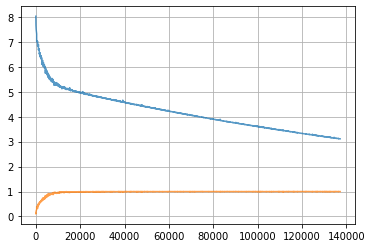

In [5]:
import matplotlib.pyplot as plt 
dat = loss_per_batch.history['loss']
dat2 = loss_per_batch.history['accuracy']
plt.plot(range(len(dat)), dat, alpha=0.75)
plt.plot(range(len(dat2)), dat2, alpha=0.75)
plt.grid()
plt.show() 

In [6]:
from scipy.optimize import curve_fit

In [7]:
iters = np.array(list(range(1, len(dat)+1)))
popt, pcov = curve_fit(func, iters, np.array(dat),p0=[0.01, 1, 1])

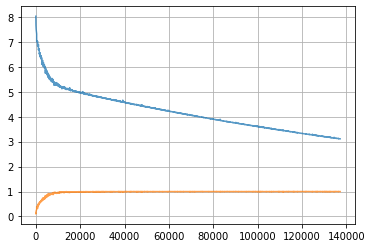

In [8]:
import matplotlib.pyplot as plt 
dat = loss_per_batch.history['loss']
dat2 = loss_per_batch.history['accuracy']
interp = func(iters, popt[0], popt[1], popt[2])
# plt.plot(iters, interp)
plt.plot(iters, dat, alpha=0.75)
plt.plot(iters, dat2, alpha=0.75)
plt.grid()
plt.show() 

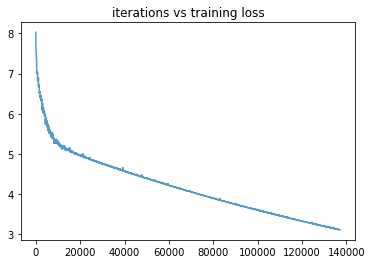

beta0, beta1, beta2:  [3.41904191e-06 2.35007303e-01 1.84888193e+00]


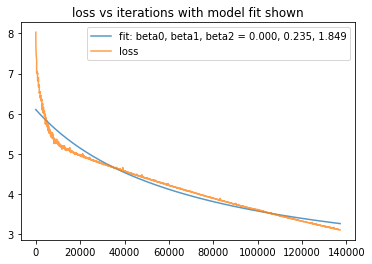

In [11]:
# plotting, parameter estimation and saving as dataframe
import pandas as pd
loss = loss_per_batch.history['loss']
iters = np.array(list(range(1, len(loss)+1)))
acc = loss_per_batch.history['accuracy']
df = pd.DataFrame(np.stack([iters, loss, acc], axis=-1), columns=['iterations', 'loss', 'acc'])
df.to_csv('Resnet56' + "_" + 'K80' + ".csv", index=False)

import matplotlib.pyplot as plt 
plt.figure()
plt.title("iterations vs training loss")
plt.plot(df.iterations, df.loss, alpha=0.75)
plt.show() 

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, df.iterations, df.loss, p0=[0.001, 0.1, 1]) 
print("beta0, beta1, beta2: ", popt)

import matplotlib.pyplot as plt 
interp = func(df.iterations, *popt)
plt.figure() 
plt.title("loss vs iterations with model fit shown")
plt.plot(df.iterations, interp, alpha=0.75, label='fit: beta0, beta1, beta2 = %.3f, %.3f, %.3f' % (popt[0], popt[1], popt[2]))
plt.plot(df.iterations, df.loss, alpha=0.75, label='loss')
plt.legend()
plt.savefig("iterations_fit_vs_training_loss.JPG")
plt.show()